In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import os
import re

In [3]:
def read_problem_set(instance, n_edges):
    with open(instance, 'r') as f:
        lines = f.readlines()
        assert lines[4] == "EDGE_WEIGHT_TYPE : EUC_2D\n"
        assert lines[5] == "NODE_COORD_SECTION\n"
        n_nodes = int(lines[3].split(" ")[-1])
        x = []
        for i in range(n_nodes):
            line = [float(_) for _ in lines[6 + i].strip().split()]
            assert len(line) == 3
            assert line[0] == i + 1
            x.append([line[1], line[2]])
        x = np.array(x)
        scale = max(x[:, 0].max() - x[:, 0].min(), x[:, 1].max() -x[:, 1].min()) * (1 + 2 * 1e-4)
        x = x - x.min(0).reshape(1, 2)
        x = x / scale
        x = x + 1e-4
        if x[:, 0].max() > x[:, 1].max():
            x[:, 1] += (1 - 1e-4 - x[:, 1].max()) / 2
        else:
            x[:, 0] += (1 - 1e-4 - x[:, 0].max()) / 2
        x = x.reshape( n_nodes, 2)
        dist = np.sqrt

    dist = x.reshape(n_nodes, 1, 2) - x.reshape(1, n_nodes, 2)
    dist = np.sqrt((dist ** 2).sum(-1))
    edge_index = np.argsort(dist, -1)
    # edge_feat = dist[np.arange(batch_size).reshape(-1, 1, 1), np.arange(n_nodes).reshape(1, -1, 1), edge_index]
    inverse_edge_index = -np.ones(shape=[n_nodes, n_nodes], dtype="int")
    inverse_edge_index[edge_index, np.arange(n_nodes).reshape(-1, 1)] = np.arange(n_edges).reshape(1, -1) + np.arange(n_nodes).reshape(-1, 1) * n_edges
    inverse_edge_index = inverse_edge_index[np.arange(n_nodes).reshape(-1, 1), edge_index]
    
    return x, edge_index, inverse_edge_index

In [4]:
def read_optimal(optimal):
    with open(optimal, 'r') as f:
        line = f.readline()

    opt = [int(i)-1 for i in line.split(' ')]
    return opt
        

In [5]:
def plot_scatter(x, edge_index, inv_edge_index, point_ref = 0, num_points = 8):
    #point_ref = 0 #point we want to make the reference
    #num_points = 8 #number of points around the reference point
    
    dimension = len(x)
    fig, ax = plt.subplots(1,2)
    #plt.figure(figsize=(6.4, 15))
    psize = 100
    lsize = 12
    fsize = 20
    fig.set_size_inches(20,10)
    ax[0].scatter(x[:,0], x[:,1], s=psize, marker='.', c='blue')
    ax[1].scatter(x[:,0], x[:,1], s=psize, marker='.', c='blue')
    
    ax[0].set_aspect('equal', 'box')
    ax[1].set_aspect('equal', 'box')
   
    ax[0].set_title('# closest point to a reference point')
    ax[1].set_title('# inverse closest point to a reference point')
    #cloisest points
    for i in range(num_points):
        point = x[edge_index[point_ref, i+1]]
        ax[0].scatter(point[0], point[1], marker='o', c='darkblue')
        ax[0].text(point[0], point[1], i+1, size=fsize)

    #inverse points
    print(dimension)
    for i in range(num_points):
        point_and_pos = inv_edge_index[point_ref, i+1]
        
        point = x[point_and_pos // dimension]
        pos = point_and_pos % dimension
        ax[1].scatter(point[0], point[1], marker='o', c='darkblue')
        ax[1].text(point[0], point[1], pos, size=fsize)

    ax[0].scatter(x[point_ref,0], x[point_ref,1], s=psize, marker='x', c='red')
    ax[1].scatter(x[point_ref,0], x[point_ref,1], s=psize, marker='x', c='red')

In [7]:
def build_distribution_list(x, edge_index, inv_edge_index, opt, num_points=8):
    stats = {}
    dimension = len(x)
    for i in range(num_points):
        stats[str(i+1)] = 0

    for idx, x in enumerate(opt[0:-1]):
        next = opt[idx+1]
        
        pos = list(edge_index[x]).index(next)
        stats[str(min(pos, num_points))] += 1
        pos_inv = inv_edge_index[x, pos] % dimension
        stats[str(min(pos_inv, num_points))] += 1

    return stats

In [8]:
dimension = 100
inst_n = 0
instance = f'./result/{str(dimension)}/tsp/{inst_n}.tsp'
optimal = f'./result/{str(dimension)}/bestrun/{inst_n}.txt'
n_closest = 9

#plot_scatter(x, edge_index, inv_edge_index, 15)

l_stats = []
for inst_n in trange(1000):
    instance = f'./result/{str(dimension)}/tsp/{inst_n}.tsp'
    optimal = f'./result/{str(dimension)}/bestrun/{inst_n}.txt'

    x, edge_index, inv_edge_index = read_problem_set(instance, dimension)
    opt = read_optimal(optimal)
    stats = build_distribution_list(x, edge_index, inv_edge_index, opt, n_closest)
    l_stats.append(list(stats.values()))


100%|██████████| 1000/1000 [00:03<00:00, 286.40it/s]


In [11]:
df = pd.DataFrame(l_stats, columns=[f'>={i+1}' if i==n_closest-1 else str(i+1) for i in range(n_closest)])

100


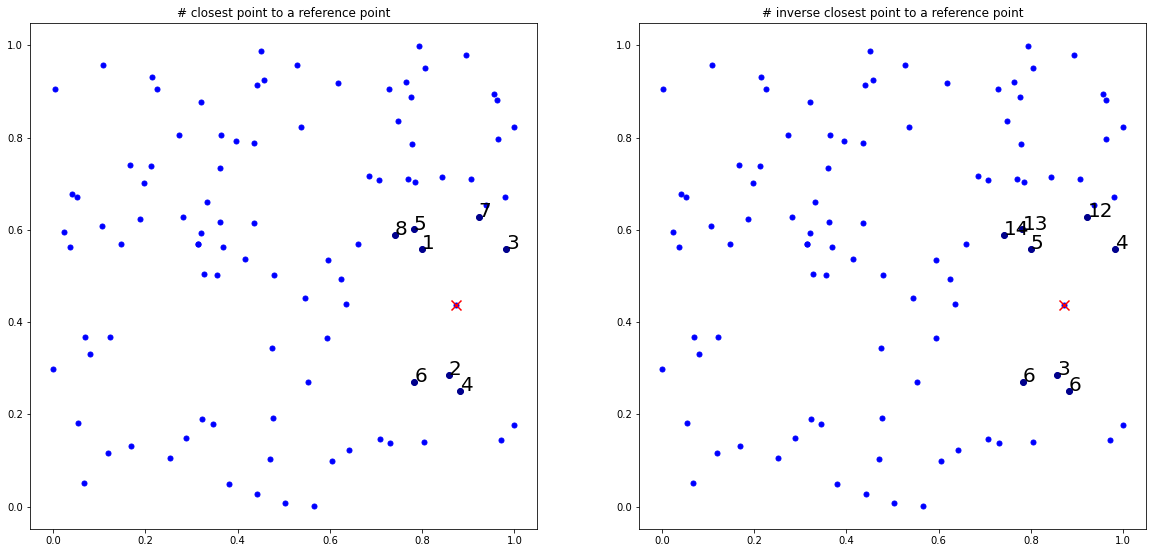

In [262]:
dimension = 100
inst_n = 0
instance = f'./result/{str(dimension)}/tsp/{inst_n}.tsp'
optimal = f'./result/{str(dimension)}/bestrun/{inst_n}.txt'
x, edge_index, inv_edge_index = read_problem_set(instance, dimension)
opt = read_optimal(optimal)

plot_scatter(x, edge_index, inv_edge_index, 15)

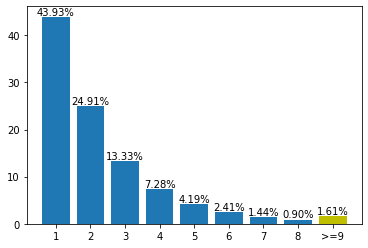

In [14]:
df2 = df.sum(axis=0)
df3 = df2 / df2.sum() * 100.0
percs = [f'{i:2.2f}%' for i in df3.values]
#print(percs)

fig, ax = plt.subplots()
bars = ax.bar(x=df3.index, height=df3.values)
bars[n_closest-1].set_color('y')
_ = ax.bar_label(bars, fmt='%2.2f%%')
#ax.set_title('Distribution of optimal edges with CL nearest')

In [131]:
print(len(opt[0:-1]))

100


In [4]:
df.describe()

,Dimension,Trials max,Trials eff,BestRun,Time
count,64.0,64.000000,64.00000,6.400000e+01,64.000000
mean,100.0,277.750000,236.71875,7.753890e+06,615.047148
std,0.0,422.094776,391.49897,7.371709e+02,1357.906956
min,100.0,1.000000,1.00000,7.753246e+06,25.100112
25%,100.0,7.750000,6.00000,7.753254e+06,42.239827
50%,100.0,55.000000,22.00000,7.753450e+06,98.105837
75%,100.0,325.000000,154.25000,7.754205e+06,752.182752
max,100.0,1000.000000,1000.00000,7.755182e+06,6624.797413


In [5]:
df.columns


Index(['VSR/Neuro', 'Dimension', 'CandidateSetType', 'Trials/TimeLimit',
       'Trials max', 'Trials eff', 'BestRun'],
      dtype='object')

In [21]:
trials = df.query("`Trials/TimeLimit`=='trials' and `VSR/Neuro`=='VSR-LKH'")

In [22]:
trials

,VSR/Neuro,Dimension,CandidateSetType,Trials/TimeLimit,Trials max,Trials eff,BestRun,Time
40,VSR-LKH,100,ALPHA,trials,1,1,7755114.047,37.334219
41,VSR-LKH,100,ALPHA,trials,10,10,7753587.576,70.951521
42,VSR-LKH,100,ALPHA,trials,100,100,7753250.944,609.736419
43,VSR-LKH,100,ALPHA,trials,1000,1000,7753247.175,5834.377290
48,VSR-LKH,100,DELAUNAY,trials,1,1,7755146.556,42.239827
49,VSR-LKH,100,DELAUNAY,trials,10,10,7753655.621,80.080238
50,VSR-LKH,100,DELAUNAY,trials,100,100,7753255.551,694.140319
51,VSR-LKH,100,DELAUNAY,trials,1000,1000,7753246.499,6603.759403
56,VSR-LKH,100,POPMUSIC,trials,1,1,7755182.114,42.061187
57,VSR-LKH,100,POPMUSIC,trials,10,10,7753669.137,79.384143


[None]

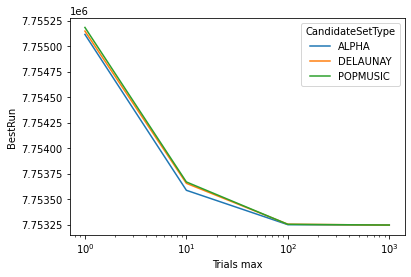

In [24]:


g_res = sns.lineplot(data=trials, x='Trials max', y='BestRun', hue='CandidateSetType' )
g_res.set(xscale='log')


[None]

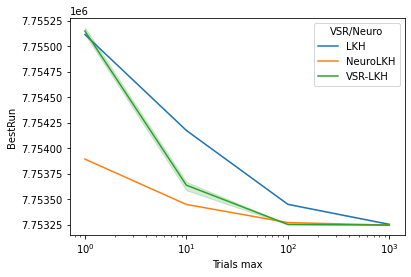

In [24]:
g_res = sns.lineplot(data=trials, x='Trials max', y='BestRun', hue='VSR/Neuro' )
g_res.set(xscale='log')

[None]

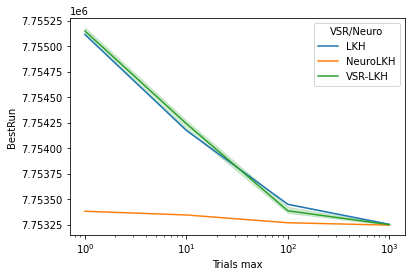

In [27]:
timelimit = df.query("`Trials/TimeLimit`=='timelimit'")

g_res = sns.lineplot(data=timelimit, x='Trials max', y='BestRun', hue='VSR/Neuro' )
g_res.set(xscale='log')

In [35]:
vsr = df.query("`Trials/TimeLimit`=='trials' and `VSR/Neuro`=='VSR-LKH'")
lkh = df.query("`Trials/TimeLimit`=='trials' and `VSR/Neuro`=='LKH' and `CandidateSetType`=='ALPHA' and `Trials max`==1000")

In [50]:
bestrun = float(lkh.head(1)['BestRun'])
bestrun
df['perc'] = (df['BestRun'] / bestrun - 1) * 100

[None]

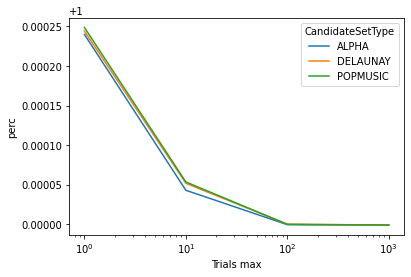

In [51]:
g_res = sns.lineplot(data=vsr, x='Trials max', y='perc', hue='CandidateSetType' )
g_res.set(xscale='log')
